# CIFAR-10 Image Classification Using ResNet (PyTorch Backend)
In this example we are going to demonstrate how to train a CIFAR-10 image classification model using a ResNet architecture on the PyTorch backend. All training details including model structure, data preprocessing, learning rate control, etc. come from https://github.com/davidcpage/cifar10-fast.

## Import the required libraries

In [1]:
import fastestimator as fe
import numpy as np
import matplotlib.pyplot as plt
import tempfile

In [2]:
#training parameters
epochs = 24
batch_size = 512
max_train_steps_per_epoch = None
max_eval_steps_per_epoch = None
save_dir = tempfile.mkdtemp()

In [3]:
# Parameters
epochs = 2
batch_size = 8
max_train_steps_per_epoch = 10
max_eval_steps_per_epoch = 10


## Step 1 - Data and `Pipeline` preparation
In this step, we will load CIFAR-10 training and validation datasets and prepare FastEstimator's pipeline.

### Load dataset 
We use a FastEstimator API to load the CIFAR-10 dataset and then get a test set by splitting 50% of the data off of the evaluation set. 

In [4]:
from fastestimator.dataset.data import cifar10

train_data, eval_data = cifar10.load_data()
test_data = eval_data.split(0.5)

### Set up a pre-processing `Pipeline`
Here we set up the data pipeline. This will involve a variety of data augmentation including: random cropping, horizontal flipping, image obscuration, and smoothed one-hot label encoding. Beside all of this, the image channels need to be transposed from HWC to CHW format due to PyTorch conventions. We set up these processing steps using `Ops` and also bundle the data sources and batch_size together into our `Pipeline`.

In [5]:
from fastestimator.op.numpyop.univariate import ChannelTranspose, CoarseDropout, Normalize, Onehot
from fastestimator.op.numpyop.meta import Sometimes
from fastestimator.op.numpyop.multivariate import HorizontalFlip, PadIfNeeded, RandomCrop

pipeline = fe.Pipeline(
    train_data=train_data,
    eval_data=eval_data,
    test_data=test_data,
    batch_size=batch_size,
    ops=[
        Normalize(inputs="x", outputs="x_out", mean=(0.4914, 0.4822, 0.4465), std=(0.2471, 0.2435, 0.2616)),
        PadIfNeeded(min_height=40, min_width=40, image_in="x_out", image_out="x_out", mode="train"),
        RandomCrop(32, 32, image_in="x_out", image_out="x_out", mode="train"),
        Sometimes(HorizontalFlip(image_in="x_out", image_out="x_out", mode="train")),
        CoarseDropout(inputs="x_out", outputs="x_out", mode="train", max_holes=1),
        ChannelTranspose(inputs="x_out", outputs="x_out"),
        Onehot(inputs="y", outputs="y_out", mode="train", num_classes=10, label_smoothing=0.2)
    ])

### Validate `Pipeline`
In order to make sure the `Pipeline` works as expected, let's visualize the output and check its size. `Pipeline.get_results` will return a batch data of pipeline output for this purpose:

In [6]:
data = pipeline.get_results()
data_xin = data["x"]
data_xout = data["x_out"]
data_yin = data["y"]
data_yout = data["y_out"]

print("the pipeline input image size: {}".format(data_xin.numpy().shape))
print("the pipeline output image size: {}".format(data_xout.numpy().shape))
print("the pipeline input label size: {}".format(data_yin.numpy().shape))
print("the pipeline output label size: {}".format(data_yout.numpy().shape))

the pipeline input image size: (8, 32, 32, 3)
the pipeline output image size: (8, 3, 32, 32)
the pipeline input label size: (8, 1)
the pipeline output label size: (8, 10)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


label_in:[9] -> label_out:[0.02 0.02 0.02 0.02 0.02 0.02 0.02 0.02 0.02 0.82]
label_in:[1] -> label_out:[0.02 0.82 0.02 0.02 0.02 0.02 0.02 0.02 0.02 0.02]
label_in:[9] -> label_out:[0.02 0.02 0.02 0.02 0.02 0.02 0.02 0.02 0.02 0.82]
label_in:[4] -> label_out:[0.02 0.02 0.02 0.02 0.82 0.02 0.02 0.02 0.02 0.02]
label_in:[6] -> label_out:[0.02 0.02 0.02 0.02 0.02 0.02 0.82 0.02 0.02 0.02]


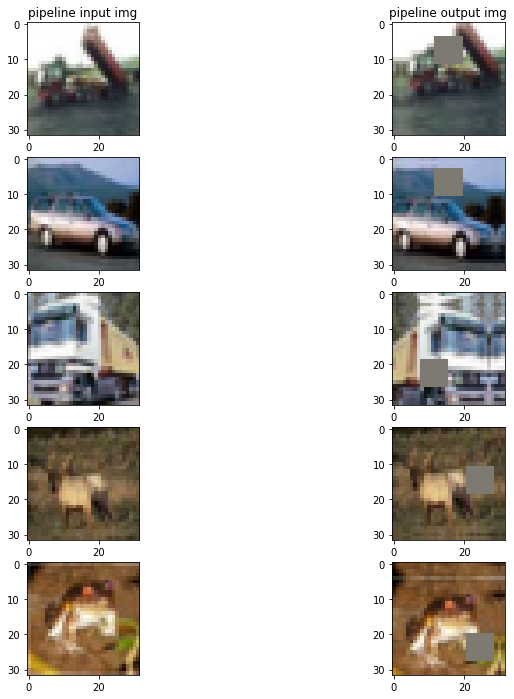

In [7]:
sample_num = 5

fig, axs = plt.subplots(sample_num, 2, figsize=(12,12))

axs[0,0].set_title("pipeline input img")
axs[0,1].set_title("pipeline output img")

for i, j in enumerate(np.random.randint(low=0, high=batch_size-1, size=sample_num)):
    # pipeline image visualization 
    img_in = data_xin.numpy()[j]
    axs[i,0].imshow(img_in)
    
    img_out = data_xout.numpy()[j].transpose((1,2,0))
    img_out[:,:,0] = img_out[:,:,0] * 0.2471 + 0.4914 
    img_out[:,:,1] = img_out[:,:,1] * 0.2435 + 0.4822
    img_out[:,:,2] = img_out[:,:,2] * 0.2616 + 0.4465
    axs[i,1].imshow(img_out)
    
    # pipeline label print
    label_in = data_yin.numpy()[j]
    label_out = data_yout.numpy()[j]
    print("label_in:{} -> label_out:{}".format(label_in, label_out))

## Step 2 - `Network` construction
**FastEstimator supports both PyTorch and TensorFlow, so this section could use either backend.** <br>
We are going to only demonstrate the PyTorch way in this example.

### Model construction
The model definitions are implemented in PyTorch and instantiated by calling `fe.build` which also associates the model with a specific optimizer.

In [8]:
import torch
import torch.nn as nn
import torch.nn.functional as fn

class FastCifar(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv0 = nn.Conv2d(3, 64, 3, padding=(1, 1))
        self.conv0_bn = nn.BatchNorm2d(64, momentum=0.8)
        self.conv1 = nn.Conv2d(64, 128, 3, padding=(1, 1))
        self.conv1_bn = nn.BatchNorm2d(128, momentum=0.8)
        self.residual1 = Residual(128, 128)
        self.conv2 = nn.Conv2d(128, 256, 3, padding=(1, 1))
        self.conv2_bn = nn.BatchNorm2d(256, momentum=0.8)
        self.residual2 = Residual(256, 256)
        self.conv3 = nn.Conv2d(256, 512, 3, padding=(1, 1))
        self.conv3_bn = nn.BatchNorm2d(512, momentum=0.8)
        self.residual3 = Residual(512, 512)
        self.fc1 = nn.Linear(512, 10)

    def forward(self, x):
        # prep layer
        x = self.conv0(x)
        x = self.conv0_bn(x)
        x = fn.leaky_relu(x, negative_slope=0.1)
        # layer 1
        x = self.conv1(x)
        x = fn.max_pool2d(x, 2)
        x = self.conv1_bn(x)
        x = fn.leaky_relu(x, negative_slope=0.1)
        x = x + self.residual1(x)
        # layer 2
        x = self.conv2(x)
        x = fn.max_pool2d(x, 2)
        x = self.conv2_bn(x)
        x = fn.leaky_relu(x, negative_slope=0.1)
        x = x + self.residual2(x)
        # layer 3
        x = self.conv3(x)
        x = fn.max_pool2d(x, 2)
        x = self.conv3_bn(x)
        x = fn.leaky_relu(x, negative_slope=0.1)
        x = x + self.residual3(x)
        # layer 4
        x = fn.max_pool2d(x, kernel_size=x.size()[2:])
        x = torch.flatten(x, 1)
        x = self.fc1(x)
        x = fn.softmax(x, dim=-1)
        return x


class Residual(nn.Module):
    def __init__(self, channel_in, channel_out):
        super().__init__()
        self.conv1 = nn.Conv2d(channel_in, channel_out, 3, padding=(1, 1))
        self.conv1_bn = nn.BatchNorm2d(channel_out)
        self.conv2 = nn.Conv2d(channel_out, channel_out, 3, padding=(1, 1))
        self.conv2_bn = nn.BatchNorm2d(channel_out)

    def forward(self, x):
        x = self.conv1(x)
        x = self.conv1_bn(x)
        x = fn.leaky_relu(x, negative_slope=0.1)
        x = self.conv2(x)
        x = self.conv2_bn(x)
        x = fn.leaky_relu(x, negative_slope=0.1)
        return x

model = fe.build(model_fn=FastCifar, optimizer_fn="adam")

### `Network` definition
`Ops` are the basic components of a network that include models, loss calculation units, and post-processing units. In this step we are going to combine those pieces together into a `Network`:  

In [9]:
from fastestimator.op.tensorop.loss import CrossEntropy
from fastestimator.op.tensorop.model import ModelOp, UpdateOp

network = fe.Network(ops=[
        ModelOp(model=model, inputs="x_out", outputs="y_pred"),
        CrossEntropy(inputs=("y_pred", "y_out"), outputs="ce", mode="train"),
        CrossEntropy(inputs=("y_pred", "y"), outputs="ce", mode="test"),
        UpdateOp(model=model, loss_name="ce", mode="train")
    ])

## Step 3 - `Estimator` definition and training
In this step, we define an `Estimator` to connect our `Network` with our `Pipeline` and set the `traces` which will compute accuracy (`Accuracy`), save our best model (`BestModelSaver`), and change the learning rate (`LRScheduler`) of our optimizer over time. We will then use `Estimator.fit` to trigger the training.

In [10]:
from fastestimator.trace.adapt import LRScheduler
from fastestimator.trace.io import BestModelSaver
from fastestimator.trace.metric import Accuracy

def lr_schedule(step):
    if step <= 490:
        lr = step / 490 * 0.4
    else:
        lr = (2352 - step) / 1862 * 0.4
    return lr * 0.1

traces = [
    Accuracy(true_key="y", pred_key="y_pred"),
    BestModelSaver(model=model, save_dir=save_dir, metric="accuracy", save_best_mode="max"),
    LRScheduler(model=model, lr_fn=lr_schedule)
]

estimator = fe.Estimator(pipeline=pipeline,
                         network=network,
                         epochs=epochs,
                         traces=traces,
                         max_train_steps_per_epoch=max_train_steps_per_epoch,
                         max_eval_steps_per_epoch=max_eval_steps_per_epoch)

estimator.fit() # start the training 

    ______           __  ______     __  _                 __            
   / ____/___ ______/ /_/ ____/____/ /_(_)___ ___  ____ _/ /_____  _____
  / /_  / __ `/ ___/ __/ __/ / ___/ __/ / __ `__ \/ __ `/ __/ __ \/ ___/
 / __/ / /_/ (__  ) /_/ /___(__  ) /_/ / / / / / / /_/ / /_/ /_/ / /    
/_/    \__,_/____/\__/_____/____/\__/_/_/ /_/ /_/\__,_/\__/\____/_/     
                                                                        



FastEstimator-Start: step: 1; num_device: 0; logging_interval: 100; 


FastEstimator-Train: step: 1; ce: 5.0723634; model_lr: 8.163265e-05; 


FastEstimator-Train: step: 10; epoch: 1; epoch_time: 1.42 sec; 


FastEstimator-BestModelSaver: Saved model to /tmp/tmpu9b21w1f/model_best_accuracy.pt
FastEstimator-Eval: step: 10; epoch: 1; accuracy: 0.1625; since_best_accuracy: 0; max_accuracy: 0.1625; 


FastEstimator-Train: step: 20; epoch: 2; epoch_time: 1.53 sec; 


FastEstimator-Eval: step: 20; epoch: 2; accuracy: 0.1; since_best_accuracy: 1; max_accuracy: 0.1625; 
FastEstimator-Finish: step: 20; total_time: 4.41 sec; model_lr: 0.0016326531; 


## Model testing
`Estimator.test` will trigger model testing using all of the test data defined in the `Pipeline`. This will allow us to check our accuracy on previously unseen data.

In [11]:
estimator.test()

FastEstimator-Test: step: 20; epoch: 2; accuracy: 0.1256; 


## Inferencing
In this step we run image inference directly using the model that we just trained. We randomly select 5 images from testing dataset and infer them image by image using `Pipeline.transform` and `Network.transform`. Please be aware that the `Pipeline` is no longer the same as it was during training, because we don't want to use data augmentation during inference. This detail was already defined in the `Pipeline` (mode = "!infer"). 

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


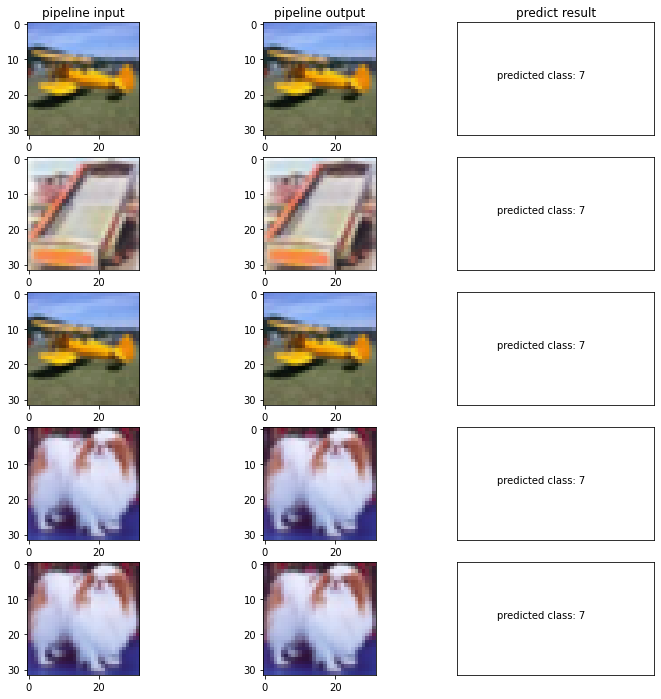

In [12]:
sample_num = 5

fig, axs = plt.subplots(sample_num, 3, figsize=(12,12))

axs[0,0].set_title("pipeline input")
axs[0,1].set_title("pipeline output")
axs[0,2].set_title("predict result")

for i, j in enumerate(np.random.randint(low=0, high=batch_size-1, size=sample_num)):
    data = {"x": test_data["x"][j]}
    axs[i,0].imshow(data["x"], cmap="gray")
    
    # run the pipeline
    data = pipeline.transform(data, mode="infer") 
    img = data["x_out"].squeeze(axis=0).transpose((1,2,0))
    img[:,:,0] = img[:,:,0] * 0.2471 + 0.4914 
    img[:,:,1] = img[:,:,1] * 0.2435 + 0.4822
    img[:,:,2] = img[:,:,2] * 0.2616 + 0.4465
    axs[i,1].imshow(img)
    
    # run the network
    data = network.transform(data, mode="infer")
    predict = data["y_pred"].numpy().squeeze(axis=(0))
    axs[i,2].text(0.2, 0.5, "predicted class: {}".format(np.argmax(predict)))
    axs[i,2].get_xaxis().set_visible(False)
    axs[i,2].get_yaxis().set_visible(False)